In [ ]:
mkdir Particle_Images

In [ ]:
cd Particle_Images

/content/Particle_Images


In [ ]:
mkdir data/

In [ ]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2025-03-21 13:40:48--  https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.28, 128.142.53.35, 128.142.170.17, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.28|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/FbXw3V4XNyYB3oA/download [following]
--2025-03-21 13:40:49--  https://cernbox.cern.ch/s/FbXw3V4XNyYB3oA/download
Reusing existing connection to cernbox.cern.ch:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron     [      <=>           ] 122.95M   916KB/s    in 24s     

2025-03-21 13:41:12 (5.22 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [128927319]

--2025-03-21 13:41:12--  https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.28, 128.14

In [ ]:
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all
import h5py
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.models import resnet34, efficientnet_b7
from torchvision import transforms
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
lr_init     = 1e-4    # Initial learning rate
batch_size  = 128      # Training batch size
num_samples = 211599 # Maximum of 211599
train_size = int((0.8 * num_samples) // 1)
valid_size = int((0.1 * num_samples) // 1)
test_size = int((0.1 * num_samples) // 1) # Needs to be set to 21159 for final eval
num_epochs = 10

In [ ]:
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

In [ ]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = train_stop, train_stop+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = valid_stop, valid_stop+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

X_train = np.moveaxis(X_train, 3, 1)
X_valid = np.moveaxis(X_valid, 3, 1)
X_test = np.moveaxis(X_test, 3, 1)

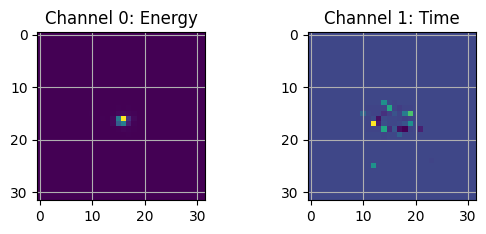

In [ ]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,0,:,:])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,1,:,:])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.show()

In [ ]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None, device='cpu'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    model.to(device)  # Move the model to the specified device

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        X = X.to(device)
        y = y.to(device)
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            y = y.to(proper_dtype)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                y_val = y_val.to(proper_dtype)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, y_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        if scheduler is not None:
            scheduler.step(val_loss)

    return history, model

In [ ]:
def test_model(model, data_loader, criterion, metric=None, device='cpu'):
    model.to(device)  # Move the model to the specified device

    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0  # Initialize the total loss and metric values
    total_metric = 0.0

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(data_loader))
        X = X.to(device)
        y = y.to(device)
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")


    with torch.no_grad():  # Disable gradient tracking
        for batch in data_loader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y = y.to(proper_dtype)
            # Pass the data to the model and make predictions
            outputs = model(X)

            # Compute the loss
            loss = criterion(outputs, y)

            # Add the loss and metric for the batch to the total values
            total_loss += loss.item()

            if metric is not None:
                total_metric += metric(outputs, y)
            else:
                total_metric += 0.0

    # Average loss and metric for the entire dataset
    avg_loss = total_loss / len(data_loader)
    avg_metric = total_metric / len(data_loader)

    print(f'Test Loss: {avg_loss:.4f}, Test Metric: {avg_metric:.4f}')

    return avg_loss, avg_metric

In [ ]:
def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [ ]:
class DualChannelResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(DualChannelResNet, self).__init__()

        self.resnet_channel1 = resnet34()
        self.resnet_channel2 = resnet34()

        self.resnet_channel1.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet_channel2.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)


        feature_dim = self.resnet_channel1.fc.in_features

        self.resnet_channel1.fc = nn.Identity()
        self.resnet_channel2.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(feature_dim * 2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):

        x1 = x[:, 0:1, :, :]  # Channel 1
        x2 = x[:, 1:2, :, :]  # Channel 2


        features1 = self.resnet_channel1(x1)
        features2 = self.resnet_channel2(x2)

        combined_features = torch.cat((features1, features2), dim=1)

        output = self.classifier(combined_features)

        return output

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.copy()).float()
        self.y = torch.from_numpy(y.copy()).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = ClassificationDataset(X_train, y_train)
valid_data = ClassificationDataset(X_valid, y_valid)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

In [ ]:
model = DualChannelResNet()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay= 0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 15
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2)
history, model = train_and_validate(train_loader, valid_loader, model, optimizer, criterion, num_epochs, metric=accuracy_metric, scheduler=scheduler, device=device)

Epoch [1/15], Train Loss: 0.5849, Train Metric: 0.7000, Val Loss: 0.5622, Val Metric: 0.7199
Epoch [2/15], Train Loss: 0.5635, Train Metric: 0.7162, Val Loss: 0.5681, Val Metric: 0.7115
Epoch [3/15], Train Loss: 0.5573, Train Metric: 0.7208, Val Loss: 0.5525, Val Metric: 0.7245
Epoch [4/15], Train Loss: 0.5535, Train Metric: 0.7246, Val Loss: 0.5462, Val Metric: 0.7319
Epoch [5/15], Train Loss: 0.5493, Train Metric: 0.7267, Val Loss: 0.5587, Val Metric: 0.7193
Epoch [6/15], Train Loss: 0.5474, Train Metric: 0.7288, Val Loss: 0.5569, Val Metric: 0.7236
Epoch [7/15], Train Loss: 0.5447, Train Metric: 0.7305, Val Loss: 0.5719, Val Metric: 0.7061
Epoch [8/15], Train Loss: 0.5354, Train Metric: 0.7369, Val Loss: 0.5353, Val Metric: 0.7352
Epoch [9/15], Train Loss: 0.5337, Train Metric: 0.7379, Val Loss: 0.5329, Val Metric: 0.7377
Epoch [10/15], Train Loss: 0.5327, Train Metric: 0.7383, Val Loss: 0.5322, Val Metric: 0.7390
Epoch [11/15], Train Loss: 0.5319, Train Metric: 0.7389, Val Loss: 0.

In [ ]:
# Evaluate on validation set
score = test_model(model, valid_loader, criterion, metric=accuracy_metric, device=device)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
# IF YOUR MODEL IS TOO LARGE THEN USE THE FOLLOWING TO KEEP THE MODEL ON GPU
# AND THE DATA ON CPU
model.to(device)
model.eval()
with torch.no_grad():
  y_pred = [model(x[0].to(device)).to('cpu').detach().numpy() for x in valid_loader]
labels = [x[1] for x in valid_loader]
y_pred = np.concatenate(y_pred, axis=0)
labels = np.concatenate(labels, axis=0)
# Extract probabilities for the positive class (index 1)
fpr, tpr, _ = roc_curve(labels, y_pred[:, 1])  # Changed this line
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = test_model(model, test_loader, criterion, metric=accuracy_metric, device=device)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
# IF YOUR MODEL IS TOO LARGE THEN USE THE FOLLOWING TO KEEP THE MODEL ON GPU
# AND THE DATA ON CPU
model.to(device)
model.eval()
with torch.no_grad():
  y_pred = [model(x[0].to(device)).to('cpu').detach().numpy() for x in test_loader]
labels = [x[1] for x in test_loader]
y_pred = np.concatenate(y_pred, axis=0)
labels = np.concatenate(labels, axis=0)
# Extract probabilities for the positive class (index 1)
fpr, tpr, _ = roc_curve(labels, y_pred[:, 1])  # Changed this line
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

Test Loss: 0.5301, Test Metric: 0.7406

Validation loss / accuracy: 0.5301 / 0.7406
Validation ROC AUC: 0.8110771127004539
Test Loss: 0.5334, Test Metric: 0.7373

Test loss / accuracy: 0.5334 / 0.7373
Test ROC AUC: 0.8086061803956267


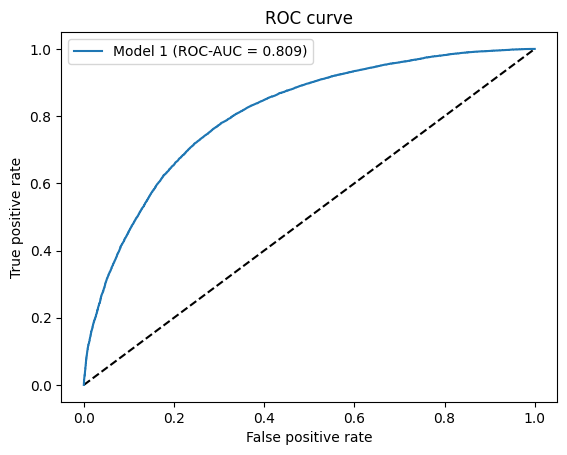

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()